In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [2]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
tmat.sample(2)

array([[[0.83582655, 0.16417345, 0.        , 0.        ],
        [0.        , 0.5       , 0.5       , 0.        ],
        [0.        , 0.        , 0.91593352, 0.08406648],
        [0.        , 0.        , 0.        , 1.        ]],

       [[0.87781522, 0.12218478, 0.        , 0.        ],
        [0.        , 0.601007  , 0.398993  , 0.        ],
        [0.        , 0.        , 0.86945724, 0.13054276],
        [0.        , 0.        , 0.        , 1.        ]]])

In [4]:
T = tmat.sample(1)
f = [0.8,0,0,0]
for i in range(10):
    f = f @ T[0]
    print(f, np.sum(f))

[0.6779767 0.1220233 0.        0.       ] 0.8
[0.5745655  0.19818012 0.02725438 0.        ] 0.7999999999999999
[0.48692752 0.24155381 0.06963342 0.00188525] 0.8
[0.41265689 0.26187246 0.11876869 0.00670196] 0.8000000000000002
[0.3497147  0.26632444 0.1690434  0.01491747] 0.8
[0.29637302 0.26018152 0.21683486 0.0266106 ] 0.7999999999999999
[0.2511675  0.2472745  0.25994843 0.04160958] 0.8
[0.21285714 0.23035514 0.29719689 0.05959082] 0.7999999999999999
[0.18039022 0.21137135 0.32808979 0.08014864] 0.7999999999999999
[0.15287546 0.19167551 0.35260565 0.10284338] 0.8


In [5]:
# starting fractions
def make_starts(N):
    start = np.zeros((N, M, C))
    # pick 2 starting patches
    seeds = [[0, 1]]
    for i in range(N):
        for j in np.random.randint(0, M, size=5): #seeds:
            start[i,j,compartments.index('I')] = np.abs(ss.norm.rvs(loc=0.05, scale=0.01))
    return start

## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [6]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 16
outs = []
for b in tqdm.tqdm(range(batches)):
    start = make_starts(N)
    Rmat = np.tile(R[np.newaxis,:,:], [N,1,1])
    infect = maxentep.contact_infection_func(tf.constant([np.random.uniform(0.01,0.25) for _ in range(N)]),
                                            infections_compartments)
    T = tmat.sample(N)
    model = MetaModel(start, Rmat, T, infect)
    outs.append(model.run(1000))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [02:29<00:00,  9.35s/it]


(4096, 1000, 62, 5)


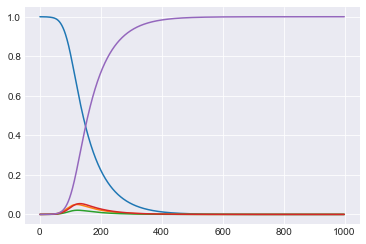

In [7]:
plt.plot(trajs[2,:,0,:])

## Make quantile Plots

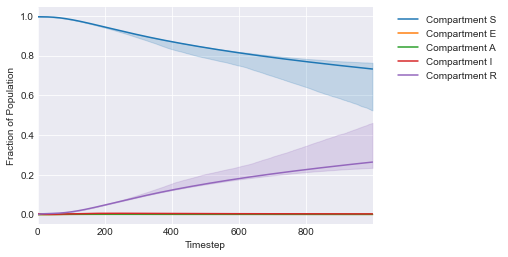

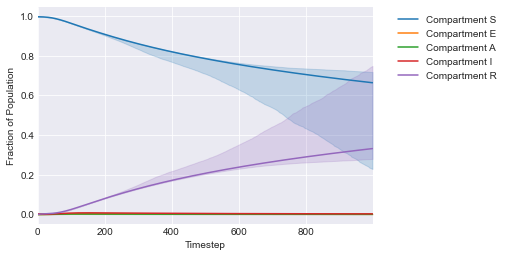

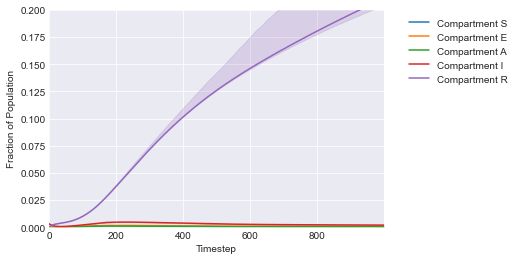

In [8]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [9]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,900, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty)
    #p = maxentep.EmptyPrior()
    r = maxentep.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [10]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-2), 'mean_squared_error')

In [11]:
history = model.fit(trajs, batch_size=16, epochs=10, verbose=0)

In [12]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer_laplace (Rewe multiple                  5         
_________________________________________________________________
avg_layer_laplace (AvgLayerL multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


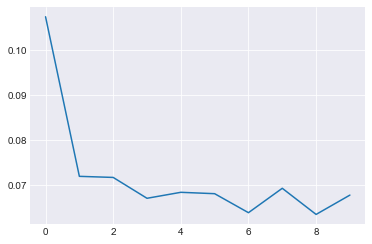

In [13]:
plt.plot(history.history['loss'])

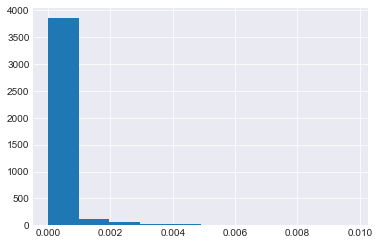

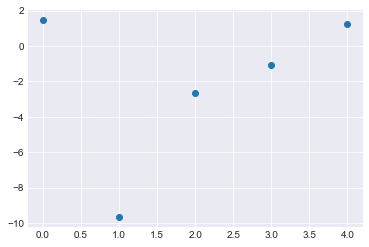

In [14]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

Plotting 62 patches in a 7 x 9 grid


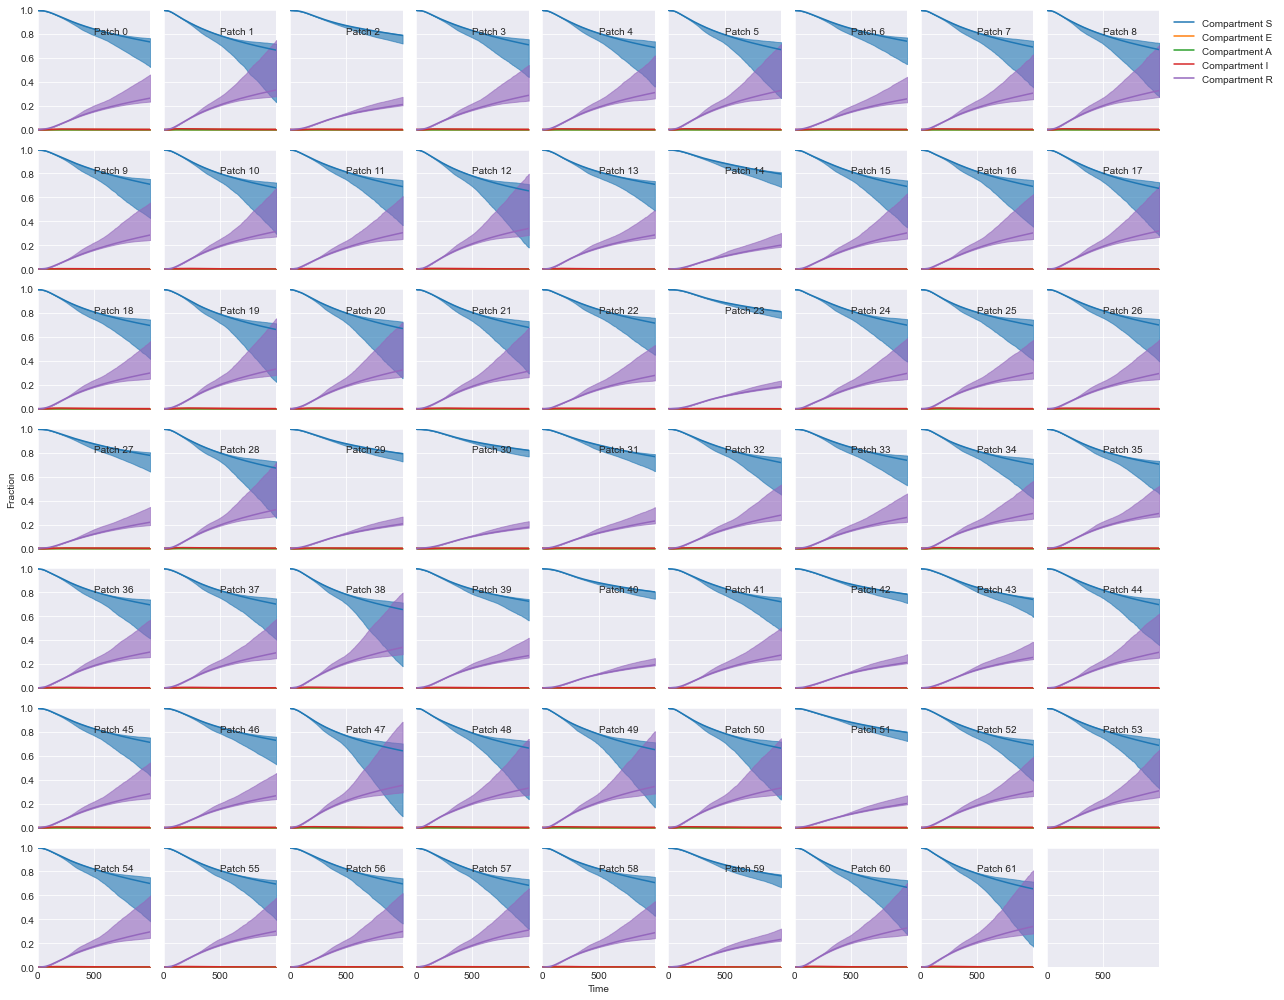

In [19]:
patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

Plotting 62 patches in a 7 x 9 grid


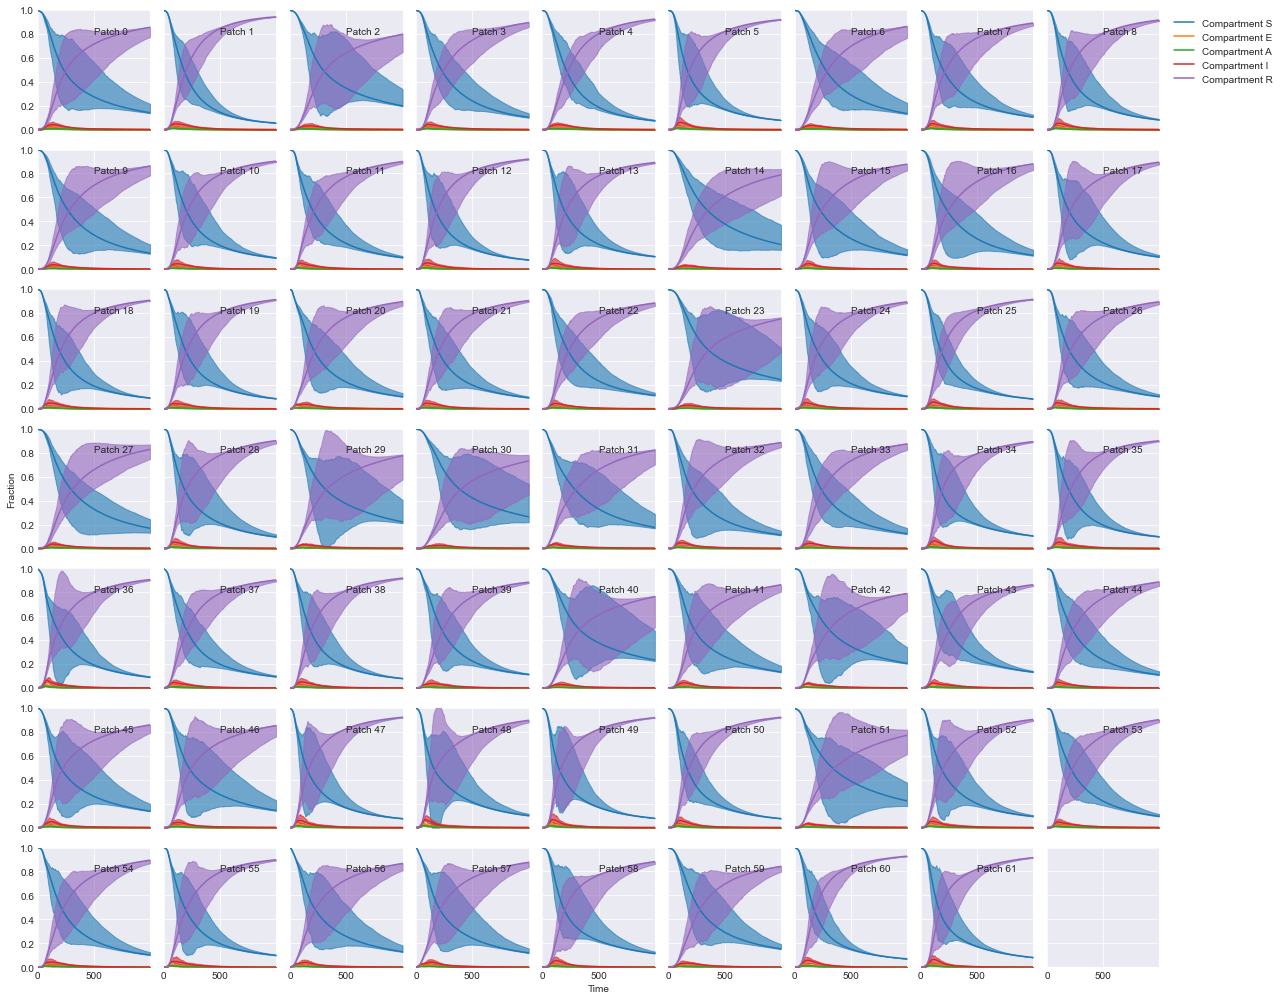

In [20]:
patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

## Final plots showing agreement

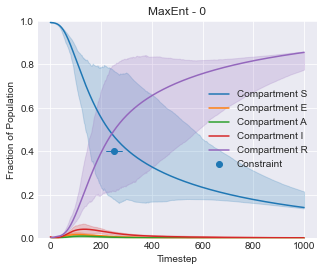

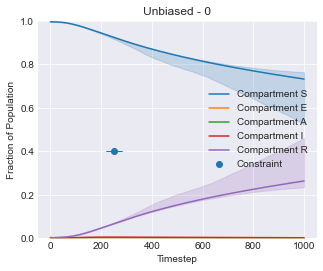

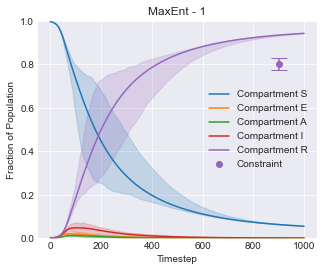

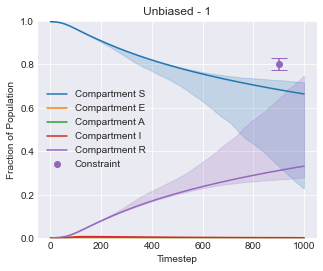

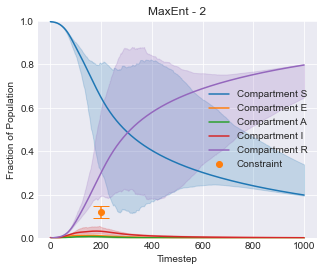

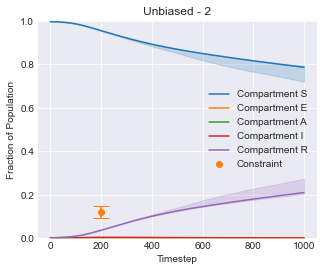

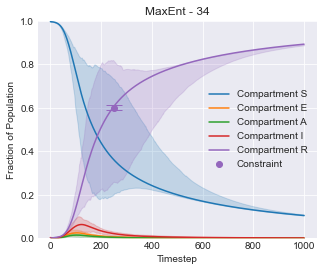

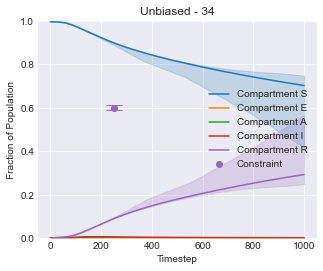

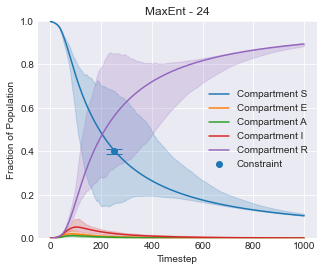

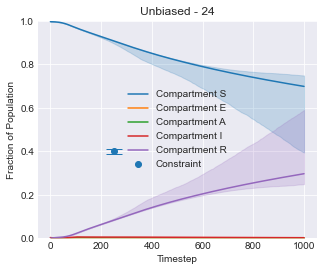

In [18]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()